In [1]:
import sys
sys.path.insert(0, 'python')
#sys.path.insert(0, '../../examples/fast-rcnn/caffe-fast-rcnn/python')
sys.path.insert(0, '../../technologies/caffe/python')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import lmdb
import caffe
from caffe.proto import caffe_pb2
import cv2
import copy
import cv
import random
DATA_ROOT="../../axard/fastquote/"

In [2]:
plt.rcParams['figure.figsize'] = (1, 1)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Have a look a the training data

Let's extract letters to LMDB, see the results and do the training

In [3]:
t = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','0','1','2','3','4','5','6','7','8','9'];

H


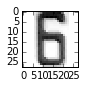

6


In [4]:
env = lmdb.open('results/train_lmdb')
def get(k):
    with env.begin() as txn:
        raw_datum = txn.get(k)

    datum = caffe.proto.caffe_pb2.Datum()
    datum.ParseFromString(raw_datum)
    flat_x = np.fromstring(datum.data, dtype=np.uint8)
    x = flat_x.reshape(datum.channels, datum.height, datum.width)
    y = datum.label
    plt.imshow(x[0,...],cmap='gray')
    plt.show()
    print t[y]

get(b'00000006')
get(b'00000009')

In [5]:
!~/technologies/caffe/build/tools/caffe train --solver=models/plates_letters/lenet_solver.prototxt

I0409 19:03:38.506580 1972867840 caffe.cpp:177] Use CPU.
I0409 19:03:38.507740 1972867840 solver.cpp:54] Initializing solver from parameters: 
test_iter: 100
test_interval: 500
base_lr: 0.01
display: 100
max_iter: 2000
lr_policy: "inv"
gamma: 0.0001
power: 0.75
momentum: 0.9
weight_decay: 0.0005
snapshot: 5000
snapshot_prefix: "lenet"
solver_mode: CPU
net: "models/plates_letters/lenet_train_test.prototxt"
I0409 19:03:38.508328 1972867840 solver.cpp:97] Creating training net from net file: models/plates_letters/lenet_train_test.prototxt
I0409 19:03:38.508549 1972867840 net.cpp:339] The NetState phase (0) differed from the phase (1) specified by a rule in layer mnist
I0409 19:03:38.508569 1972867840 net.cpp:339] The NetState phase (0) differed from the phase (1) specified by a rule in layer accuracy
I0409 19:03:38.508579 1972867840 net.cpp:50] Initializing net from parameters: 
name: "LeNet"
state {
  phase: TRAIN
}
layer {
  name: "mnist"
  type: "Data"
  top: "data"
  top: "label"
  in

In [6]:
!cp models/plates_letters/lenet_iter_2000.caffemodel models/plates_letters/deploy.caffemodel

# Test the network for classification

Let's test our previous training

In [7]:
caffe.set_mode_cpu()
net = caffe.Net('models/plates_letters/deploy.prototxt','models/plates_letters/deploy.caffemodel',caffe.TEST)

In [8]:
import transform_to_convolution
transform_to_convolution.transform( "models/plates_letters/deploy.prototxt","models/plates_letters/deploy.caffemodel","models/plates_letters/lenet_train_test_featuremap.prototxt","models/plates_letters/lenet_train_test_featuremap.caffemodel")

----------------------
Net 1 : 
------
Blobs :
('data', (1, 1, 28, 28))
('conv1', (1, 20, 24, 24))
('pool1', (1, 20, 12, 12))
('conv2', (1, 50, 8, 8))
('pool2', (1, 50, 4, 4))
('dropout', (1, 50, 4, 4))
('ip1', (1, 500))
('ip2-alpha', (1, 36))
------
Params :
('conv1', (20, 1, 5, 5), (20,))
('conv2', (50, 20, 5, 5), (50,))
('ip1', (500, 800), (500,))
('ip2-alpha', (36, 500), (36,))
----------------------
Net 2 : 
------
Blobs :
('data', (1, 1, 28, 28))
('conv1', (1, 20, 24, 24))
('pool1', (1, 20, 12, 12))
('conv2', (1, 50, 8, 8))
('pool2', (1, 50, 4, 4))
('dropout', (1, 50, 4, 4))
('ip1-conv', (1, 500, 4, 4))
('ip2-alpha-conv', (1, 36, 4, 4))
------
Params :
('conv1', (20, 1, 5, 5), (20,))
('conv2', (50, 20, 5, 5), (50,))
('ip1-conv', (500, 50, 1, 1), (500,))
('ip2-alpha-conv', (36, 500, 1, 1), (36,))
OOOO
----------------------
Net 1
Unchanged :
conv1
conv2
----------------------
Net 2
Unchanged :
conv1
conv2
----------------------
Transformation
ip1  ->  ip1-conv
ip2-alpha  ->  ip2-a

In [9]:
print("blobs {}\nparams {}".format(net.blobs.keys(), net.params.keys()))

blobs ['data', 'conv1', 'pool1', 'conv2', 'pool2', 'dropout', 'ip1', 'ip2-alpha']
params ['conv1', 'conv2', 'ip1', 'ip2-alpha']


In [10]:
im = np.array(Image.open('input/8.png'))
plt.title("original image")
plt.imshow(im)
plt.axis('off')

(-0.5, 27.5, 27.5, -0.5)

In [11]:
im.shape
im_input = im[np.newaxis, np.newaxis, :, :] * 0.00390625
net.blobs['data'].reshape(*im_input.shape)
net.blobs['data'].data[...] = im_input

In [12]:
plt.rcParams['figure.figsize'] = (10, 10)
out = net.forward(start="conv1")
plt.figure()
filt_min, filt_max = net.blobs['conv1'].data.min(), net.blobs['conv1'].data.max()
for i in range(9):
    plt.subplot(1,10,i+2)
    plt.title("filter #{} output".format(i))
    plt.imshow(net.blobs['conv1'].data[0, i], vmin=filt_min, vmax=filt_max)
print("The result is {}".format(t[net.blobs['ip2-alpha'].data[0].argmax()]))

The result is 8


#Convert letter network into feature map
Let's cast the Innerproducts layer 'ip1' and 'ip2-alpha' into convolution layers 'ip1-conv' and 'ip2-alpha-conv'

In [26]:
!diff 'models/plates_letters/lenet_train_test_withoutdata.prototxt' 'models/plates_letters/lenet_train_test_featuremap.prototxt'

1c1
< name: "LeNet"
---
> name: "LeNetConv"
82,83c82,83
<   name: "ip1"
<   type: "InnerProduct"
---
>   name: "ip1-conv"
>   type: "Convolution"
85,92c85,86
<   top: "ip1"
<   param {
<     lr_mult: 1
<   }
<   param {
<     lr_mult: 2
<   }
<   inner_product_param {
---
>   top: "ip1-conv"
>   convolution_param {
94,99c88
<     weight_filler {
<       type: "xavier"
<     }
<     bias_filler {
<       type: "constant"
<     }
---
>     kernel_size: 1
105,106c94,95
<   bottom: "ip1"
<   top: "ip1"
---
>   bottom: "ip1-conv"
>   top: "ip1-conv"
109,119c98,102
<   name: "ip2-alpha"
<   type: "InnerProduct"
<   bottom: "ip1"
<   top: "ip2-alpha"
<   param {
<     lr_mult: 1
<   }
<   param {
<     lr_mult: 2
<   }
<   inner_product_param {
---
>   name: "ip2-alpha-conv"
>   type: "Convolution"
>   bottom: "ip1-conv"
>   top: "ip2-alpha-conv"
>   convolution_param {
121,126c104
<     weight_filler {
<       type: "xavier"
<     }
<     bias_filler {
<       type: "constant"
<     }
---
> 

In [13]:
params = ['ip1', 'ip2-alpha']
# fc_params = {name: (weights, biases)}
fc_params = {pr: (net.params[pr][0].data, net.params[pr][1].data) for pr in params}

for fc in params:
    print '{} weights are {} dimensional and biases are {} dimensional'.format(fc, fc_params[fc][0].shape, fc_params[fc][1].shape)

ip1 weights are (500, 800) dimensional and biases are (500,) dimensional
ip2-alpha weights are (36, 500) dimensional and biases are (36,) dimensional


In [14]:
# Load the fully convolutional network to transplant the parameters.
net_full_conv = caffe.Net('models/plates_letters/lenet_train_test_featuremap.prototxt','models/plates_letters/lenet_iter_2000.caffemodel',caffe.TEST)
params_full_conv = ['ip1-conv', 'ip2-alpha-conv']
# conv_params = {name: (weights, biases)}
conv_params = {pr: (net_full_conv.params[pr][0].data, net_full_conv.params[pr][1].data) for pr in params_full_conv}

for conv in params_full_conv:
    print '{} weights are {} dimensional and biases are {} dimensional'.format(conv, conv_params[conv][0].shape, conv_params[conv][1].shape)

ip1-conv weights are (500, 50, 1, 1) dimensional and biases are (500,) dimensional
ip2-alpha-conv weights are (36, 500, 1, 1) dimensional and biases are (36,) dimensional


In [15]:
for pr, pr_conv in zip(params, params_full_conv):
    conv_params[pr_conv][0].flat = fc_params[pr][0].flat  # flat unrolls the arrays
    conv_params[pr_conv][1][...] = fc_params[pr][1]

In [16]:
net_full_conv.save( "models/plates_letters/lenet_train_test_featuremap.caffemodel")

(322, 800, 3)

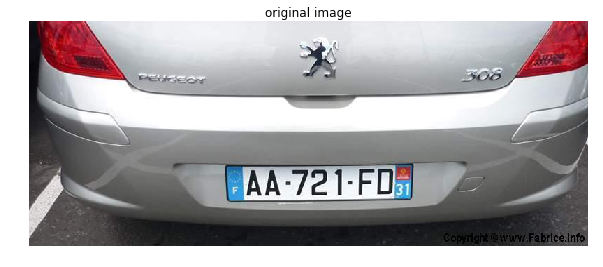

In [17]:
plt.rcParams['figure.figsize'] = (10, 5)
im = np.array(Image.open('input/p1.jpg'))
plt.title("original image")
plt.imshow(im)
plt.axis('off')
im.shape

(290, 720)

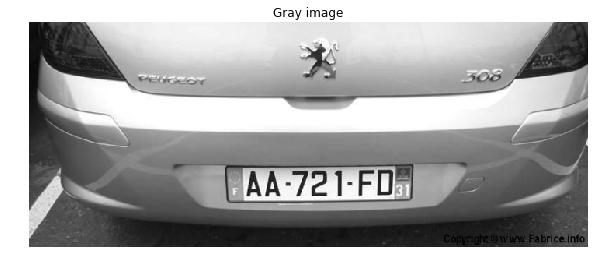

In [18]:
import cv2
im_gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
im_gray = cv2.resize(im_gray,None, fx=0.9, fy=0.9, interpolation = cv2.INTER_AREA)
plt.title("Gray image")
plt.imshow(im_gray)
plt.axis('off')
im_gray.shape

In [19]:
im_input = im_gray[np.newaxis, np.newaxis, :, :]
net_full_conv.blobs['data'].reshape(*im_input.shape)
net_full_conv.blobs['data'].data[...] = im_input 

In [20]:
out = net_full_conv.forward()
out['ip2-alpha-conv'].shape

(1, 36, 70, 177)

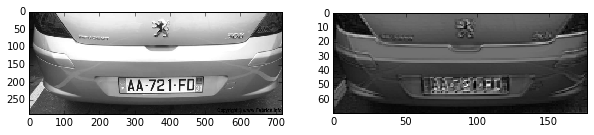

In [21]:
# show net input and confidence map (probability of the top prediction at each location)
plt.subplot(1, 2, 1)
plt.imshow(net_full_conv.blobs['data'].data[0,0])
plt.subplot(1, 2, 2)
plt.imshow(out['ip2-alpha-conv'][0,0] )

In [22]:
print net_full_conv.params["ip1-conv"][0].data

[[[[-0.05352024]]

  [[-0.00137571]]

  [[-0.03166147]]

  ..., 
  [[ 0.01346687]]

  [[-0.04965093]]

  [[-0.01867046]]]


 [[[-0.0228576 ]]

  [[-0.00299005]]

  [[ 0.00981993]]

  ..., 
  [[ 0.05313256]]

  [[ 0.05962521]]

  [[-0.04404357]]]


 [[[ 0.0264431 ]]

  [[-0.0274369 ]]

  [[ 0.06267618]]

  ..., 
  [[ 0.0005216 ]]

  [[-0.02414547]]

  [[ 0.02103752]]]


 ..., 
 [[[-0.05591788]]

  [[-0.01645956]]

  [[-0.01724311]]

  ..., 
  [[ 0.03680231]]

  [[ 0.00757341]]

  [[ 0.02619992]]]


 [[[ 0.05593994]]

  [[ 0.05517882]]

  [[-0.01626117]]

  ..., 
  [[ 0.05595806]]

  [[ 0.00422287]]

  [[-0.0518542 ]]]


 [[[-0.00720722]]

  [[ 0.00099063]]

  [[ 0.03835988]]

  ..., 
  [[-0.02109514]]

  [[ 0.0596014 ]]

  [[-0.03661998]]]]


# Compute position net

Let's create a position detection network

In [ ]:
solver = caffe.SGDSolver("python/lenet1_image/lenet_solver_position.prototxt")
solver.net.copy_from("models/plates_letters/lenet_train_test_featuremap.caffemodel")
for k, v in solver.net.blobs.items():
    print (k, v.data.shape)

In [22]:
for k, v in solver.net.params.items():
    print (k, v[0].data.shape, v[1].data.shape) 

('conv1', (20, 1, 5, 5), (20,))
('conv2', (50, 20, 5, 5), (50,))
('ip1-conv', (500, 50, 1, 1), (500,))
('ip2-alpha-conv', (36, 500, 1, 1), (36,))
('fc6-new', (4096, 3168), (4096,))
('fc7-new', (1024, 4096), (1024,))
('cls_score-new', (4, 1024), (4,))


In [23]:
print solver.net.params['ip2-alpha-conv'][0].data

[[[[-0.01879587]]

  [[ 0.07498859]]

  [[ 0.03716407]]

  ..., 
  [[-0.04203403]]

  [[-0.05132355]]

  [[ 0.02869133]]]


 [[[ 0.0103548 ]]

  [[ 0.0403614 ]]

  [[-0.18363877]]

  ..., 
  [[ 0.02521179]]

  [[ 0.03195332]]

  [[-0.00731481]]]


 [[[-0.01714628]]

  [[ 0.0278987 ]]

  [[ 0.0832042 ]]

  ..., 
  [[ 0.04361847]]

  [[ 0.09874148]]

  [[-0.00088909]]]


 ..., 
 [[[ 0.00597207]]

  [[ 0.03118473]]

  [[-0.05275441]]

  ..., 
  [[-0.00993999]]

  [[ 0.05087461]]

  [[ 0.03644937]]]


 [[[-0.03675042]]

  [[-0.11499611]]

  [[ 0.06446998]]

  ..., 
  [[-0.0777728 ]]

  [[-0.05628207]]

  [[ 0.01342954]]]


 [[[-0.01014958]]

  [[-0.00529598]]

  [[-0.15138511]]

  ..., 
  [[ 0.03411843]]

  [[-0.05971508]]

  [[-0.08467395]]]]


In [24]:
solver.net.forward()

Batch from  0  to  60
End fo


{'bbox_loss_weights': array([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0., 

In [25]:
solver.test_nets[0].forward()

Batch from  0  to  100
End fo


{'accuracy': array(0.25999999046325684, dtype=float32),
 'bbox_loss_weights': array([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,

In [26]:
solver.test_nets[0].blobs['label'].data

array([ 2.,  0.,  1.,  2.,  1.,  3.,  3.,  2.,  0.,  3.,  1.,  3.,  0.,
        3.,  2.,  1.,  0.,  3.,  1.,  1.,  3.,  2.,  3.,  1.,  2.,  3.,
        0.,  2.,  3.,  1.,  1.,  3.,  3.,  0.,  3.,  2.,  1.,  3.,  1.,
        2.,  1.,  2.,  2.,  1.,  3.,  2.,  2.,  2.,  0.,  3.,  3.,  0.,
        2.,  2.,  3.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  3.,  1.,
        1.,  3.,  1.,  3.,  0.,  2.,  2.,  1.,  0.,  1.,  2.,  0.,  3.,
        2.,  0.,  2.,  2.,  0.,  3.,  0.,  1.,  2.,  1.,  0.,  2.,  0.,
        3.,  3.,  3.,  1.,  0.,  1.,  2.,  0.,  2.], dtype=float32)

In [27]:
solver.net.blobs['label'].data

array([ 2.,  0.,  1.,  2.,  2.,  0.,  2.,  2.,  2.,  1.,  2.,  2.,  0.,
        1.,  3.,  1.,  0.,  0.,  0.,  3.,  1.,  1.,  0.,  3.,  2.,  1.,
        1.,  1.,  0.,  3.,  2.,  2.,  1.,  0.,  2.,  1.,  1.,  2.,  3.,
        0.,  3.,  2.,  2.,  3.,  1.,  3.,  3.,  2.,  2.,  0.,  2.,  0.,
        0.,  2.,  1.,  1.,  1.,  3.,  2.,  3.], dtype=float32)

In [28]:
solver.net.blobs['cls_score'].data

array([[ -6.28441668,   3.87665462, -21.30246544,  -1.12810278],
       [ -5.97952557,  16.72396851,  10.88003159,  -1.2968595 ],
       [-23.88206863,  17.79846001,  -8.94107437,  14.53769875],
       [ -3.26630211,  -4.06868076,  10.53714848, -11.94195652],
       [ 12.03981781,  -0.91646147,  -0.13036013,  -0.35644102],
       [ 10.40098   , -21.30595779,   1.74093342, -24.62659454],
       [  5.31008863, -24.74942017,  -5.052845  ,   5.28527403],
       [ -4.1900034 ,  14.07487774,  -5.43852997,  -5.89475679],
       [  7.99182224,  10.47726822,   5.23036289,  -0.43969011],
       [ 24.73430634,  -9.57747173,   2.51255441,   7.51437187],
       [  1.3552115 ,   3.03280449,   2.51923895,  -8.72305775],
       [ -4.82062292,   0.6870718 ,  13.44057846, -17.00654984],
       [  4.43894958, -10.12832546,  -5.21854162,  22.68471909],
       [  9.1190834 ,  12.57095718, -22.1116848 ,  17.23061562],
       [ -0.10965204,   5.88670921,  -3.61655116,   5.24099779],
       [ -2.93012238,   4

In [29]:
solver.step(1)

Batch from  0  to  100
End fo
Batch from  0  to  60
End fo


In [30]:
solver.net.blobs['fc6'].data

array([[   0.        ,    0.        ,   44.20033264, ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,   28.72623062,    0.        , ...,    0.        ,
         154.66325378,    0.        ],
       [   0.        ,    0.        ,   47.05076981, ...,    0.        ,
           0.        ,    0.        ],
       ..., 
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
          66.90126801,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,   73.01483154, ...,    0.        ,
         130.7199707 ,    0.        ]], dtype=float32)

In [31]:
niter=800
for it in range(niter):
    print "SGD2 ", it
    solver.step(1)  # SGD by Caffe
    print "Train loss", solver.net.blobs['loss_cls'].data

    # print "Test forward"
    solver.test_nets[0].forward(start='conv1')
    print "Test loss", solver.test_nets[0].blobs['loss_cls'].data
    #print solver.test_nets[0].blobs['label'].data
    #print solver.test_nets[0].blobs['cls_score'].data
    print "Test accuracy", solver.test_nets[0].blobs['accuracy'].data

SGD2  0
Batch from  0  to  60
End fo
Train loss 53.207485199
Test loss 44.2844619751
Test accuracy 0.239999994636
SGD2  1
Batch from  0  to  60
End fo
Train loss 47.8380775452
Test loss 16.8344192505
Test accuracy 0.25
SGD2  2
Batch from  0  to  60
End fo
Train loss 26.0187969208
Test loss 3.70716786385
Test accuracy 0.189999997616
SGD2  3
Batch from  0  to  60
End fo
Train loss 8.68579387665
Test loss 1.85610318184
Test accuracy 0.230000004172
SGD2  4
Batch from  0  to  60
End fo
Train loss 3.6195526123
Test loss 1.45226812363
Test accuracy 0.180000007153
SGD2  5
Batch from  0  to  60
End fo
Train loss 2.10133624077
Test loss 1.41305196285
Test accuracy 0.159999996424
SGD2  6
Batch from  0  to  60
End fo
Train loss 1.71017885208
Test loss 1.39544260502
Test accuracy 0.170000001788
SGD2  7
Batch from  0  to  60
End fo
Train loss 1.50179553032
Test loss 1.38592624664
Test accuracy 0.209999993443
SGD2  8
Batch from  0  to  60
End fo
Train loss 1.52104580402
Test loss 1.38221585751
Test a

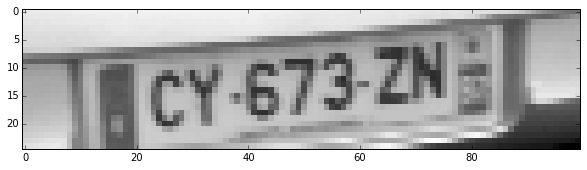

Predicted : 1
Label : 1.0


Predicted : 2
Label : 2.0


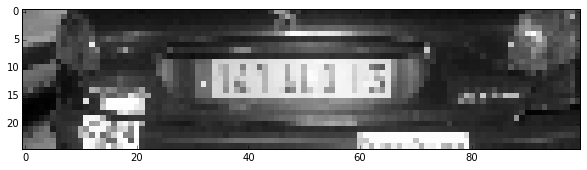

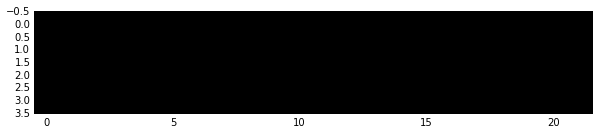

Predicted : 0
Label : 0.0


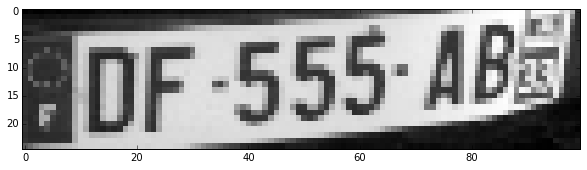

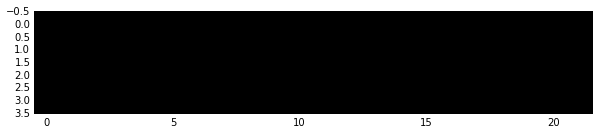

Predicted : 2
Label : 2.0


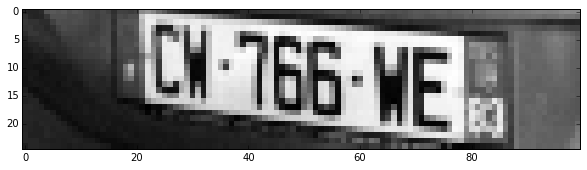

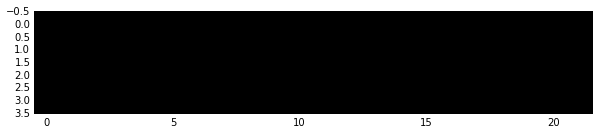

Predicted : 1
Label : 1.0


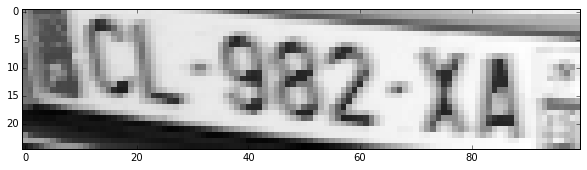

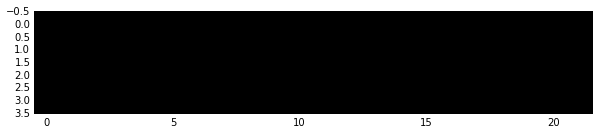

Predicted : 2
Label : 2.0


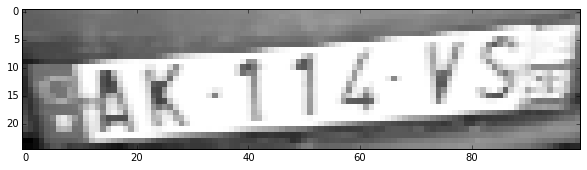

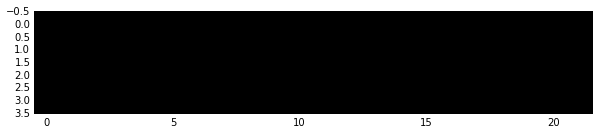

Predicted : 2
Label : 2.0


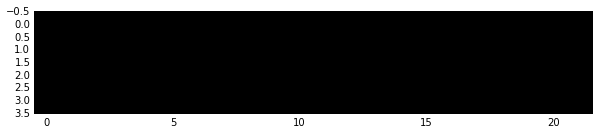

Predicted : 2
Label : 3.0


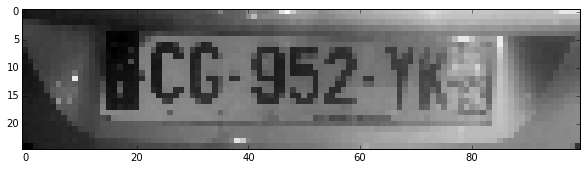

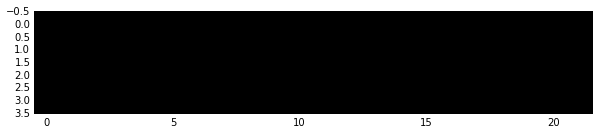

Predicted : 1
Label : 1.0


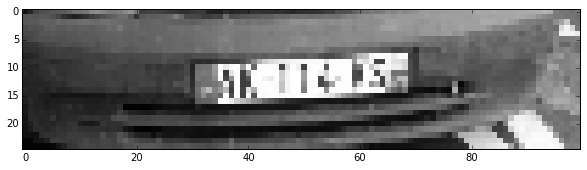

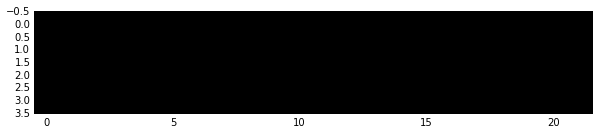

Predicted : 0
Label : 0.0


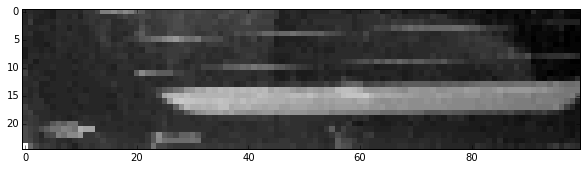

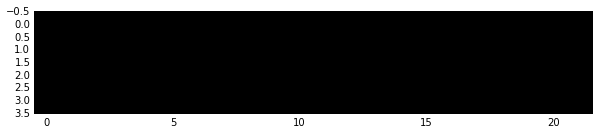

Predicted : 1
Label : 3.0


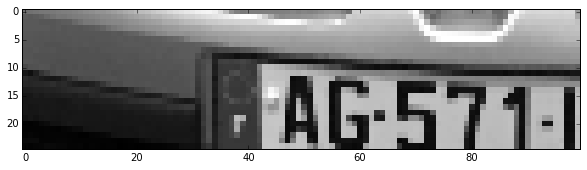

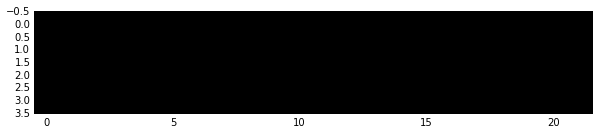

Predicted : 0
Label : 3.0


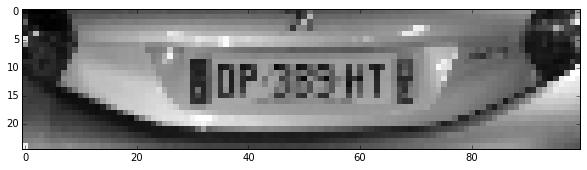

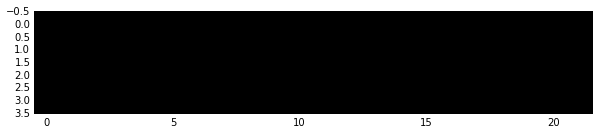

Predicted : 0
Label : 0.0


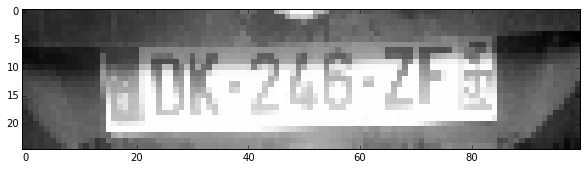

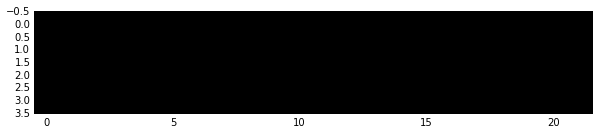

Predicted : 1
Label : 1.0


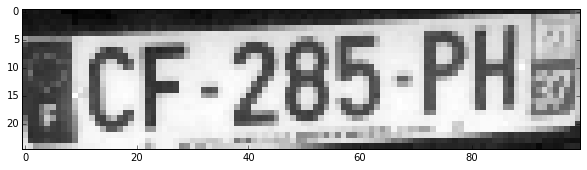

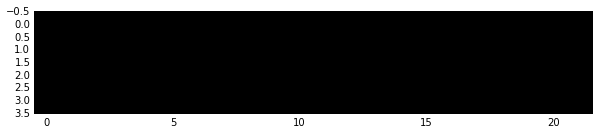

Predicted : 2
Label : 2.0


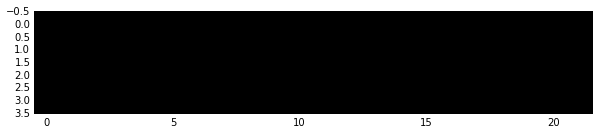

Predicted : 1
Label : 1.0


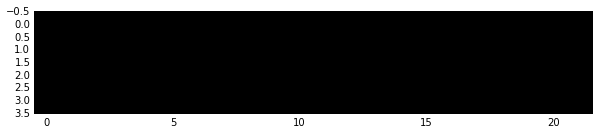

Predicted : 3
Label : 3.0


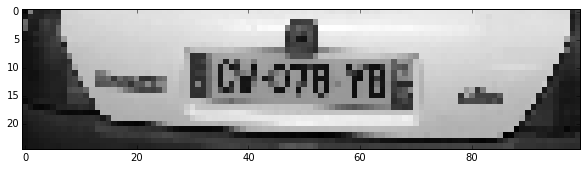

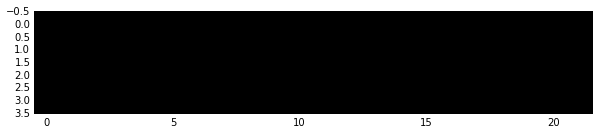

Predicted : 0
Label : 0.0


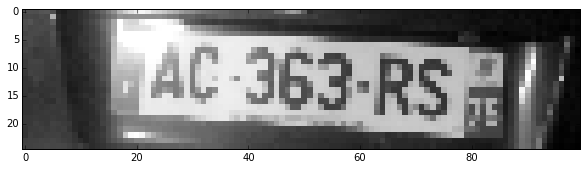

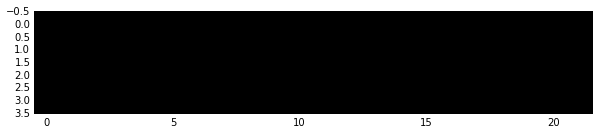

Predicted : 1
Label : 1.0


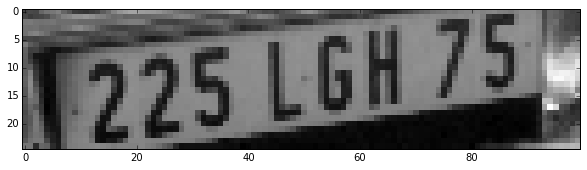

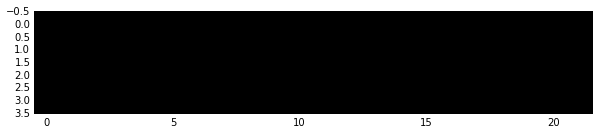

Predicted : 2
Label : 2.0


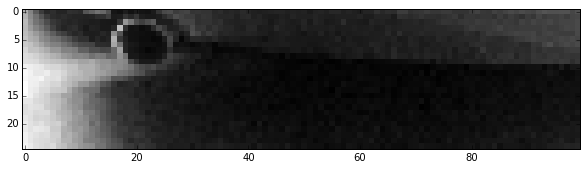

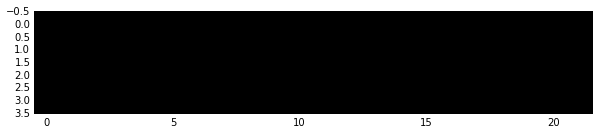

Predicted : 3
Label : 3.0


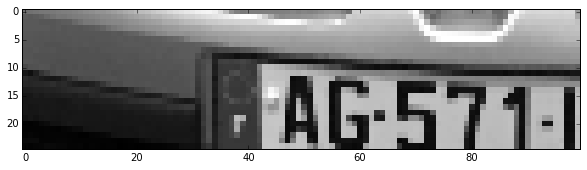

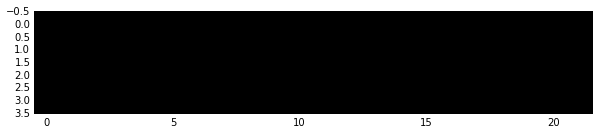

Predicted : 0
Label : 3.0


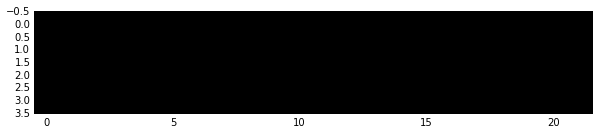

Predicted : 3
Label : 1.0


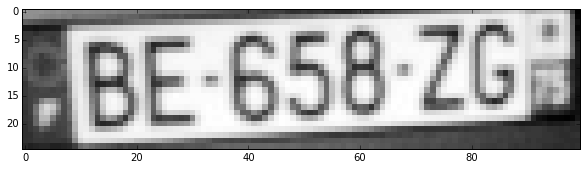

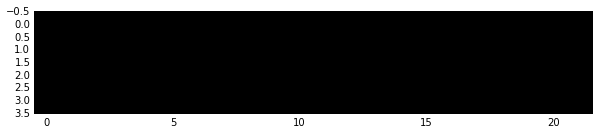

Predicted : 2
Label : 2.0


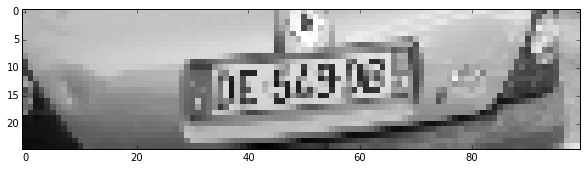

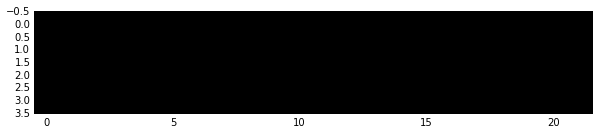

Predicted : 0
Label : 0.0


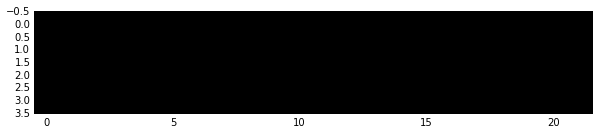

Predicted : 3
Label : 3.0


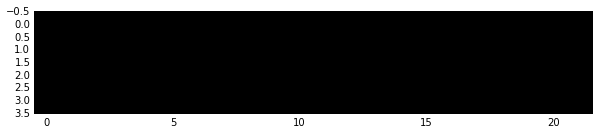

Predicted : 0
Label : 0.0


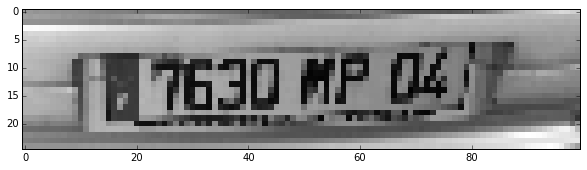

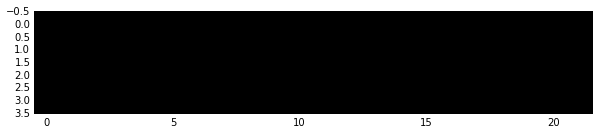

Predicted : 1
Label : 1.0


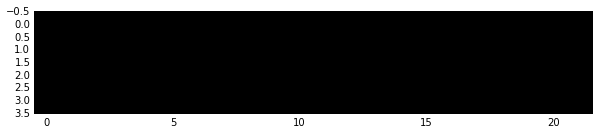

Predicted : 1
Label : 1.0


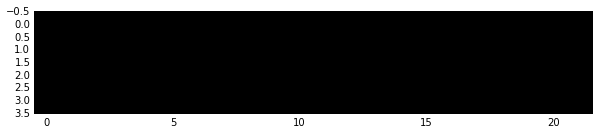

Predicted : 3
Label : 3.0


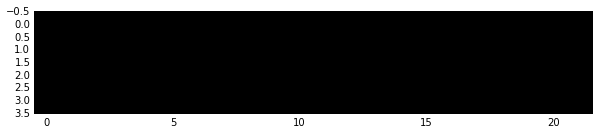

Predicted : 2
Label : 2.0


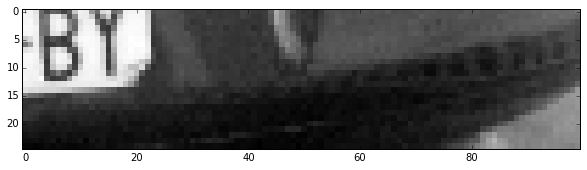

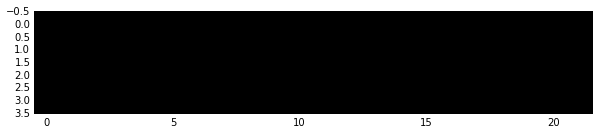

Predicted : 3
Label : 3.0


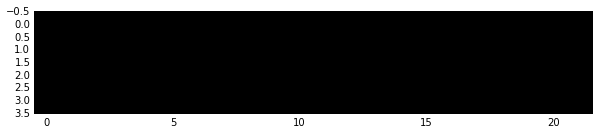

Predicted : 0
Label : 0.0


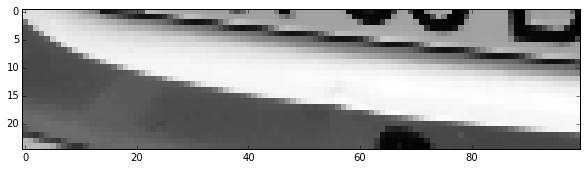

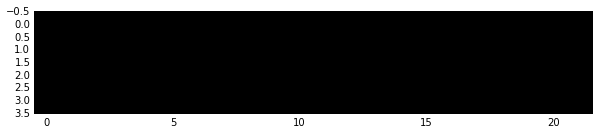

Predicted : 3
Label : 3.0


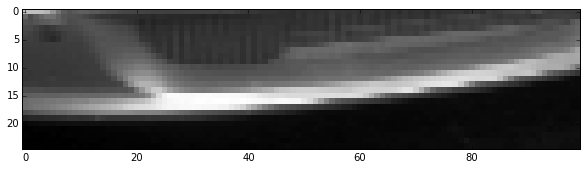

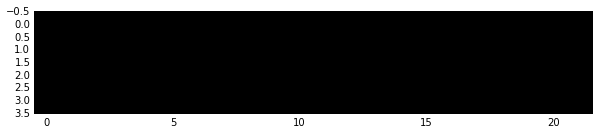

Predicted : 0
Label : 3.0


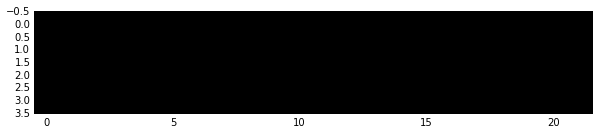

Predicted : 0
Label : 0.0


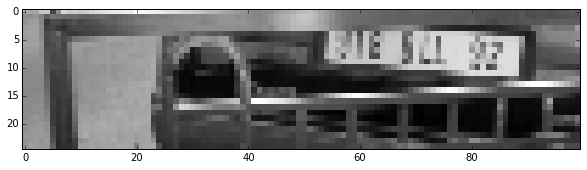

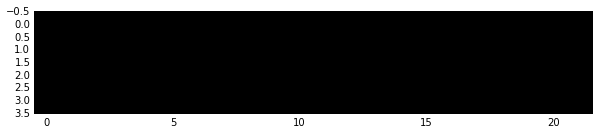

Predicted : 3
Label : 3.0


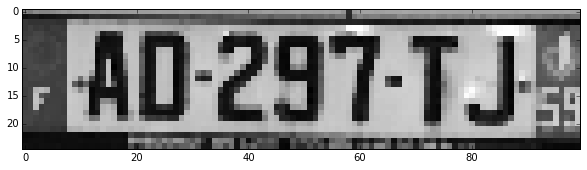

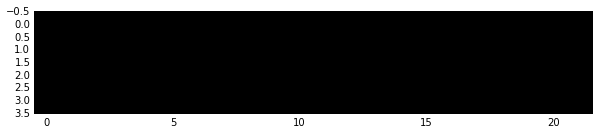

Predicted : 2
Label : 2.0


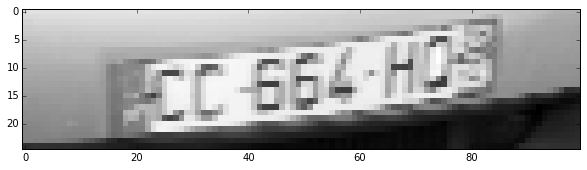

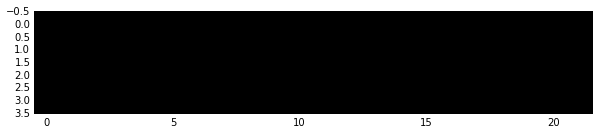

Predicted : 1
Label : 1.0


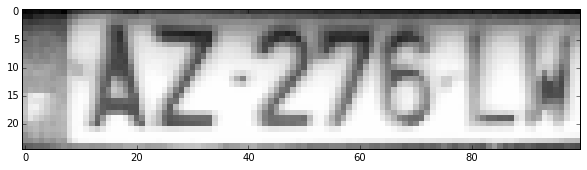

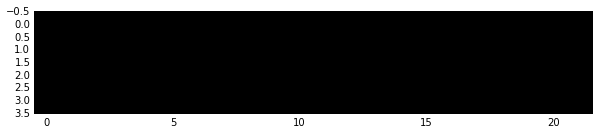

Predicted : 2
Label : 2.0


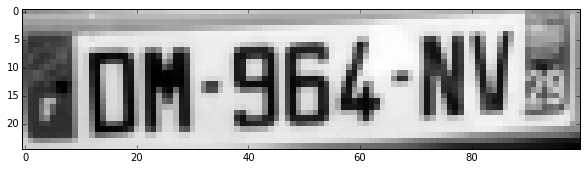

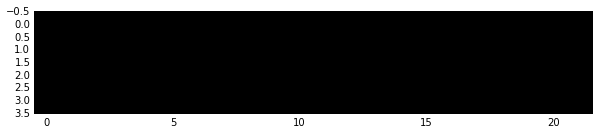

Predicted : 2
Label : 2.0


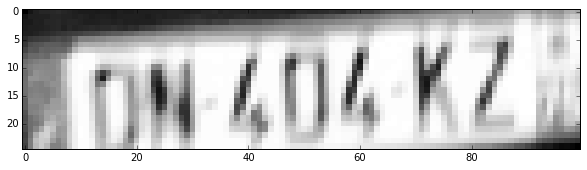

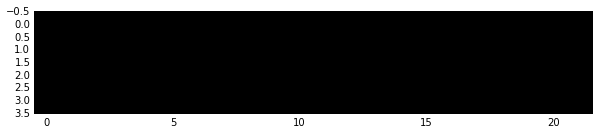

Predicted : 2
Label : 2.0


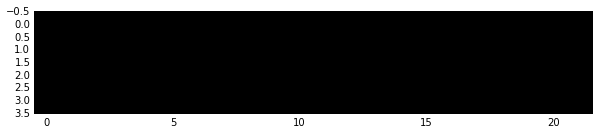

Predicted : 2
Label : 2.0


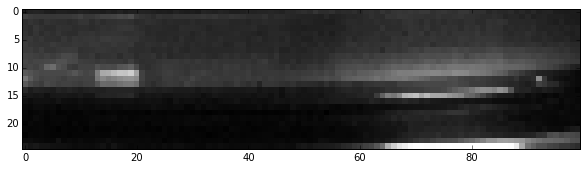

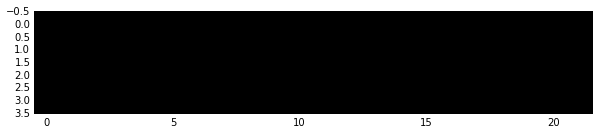

Predicted : 2
Label : 3.0


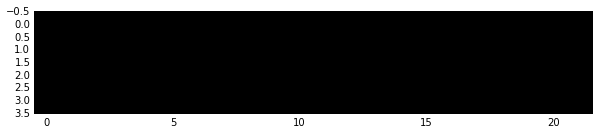

Predicted : 3
Label : 3.0


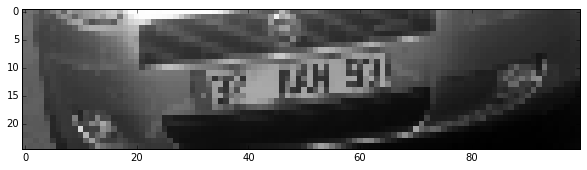

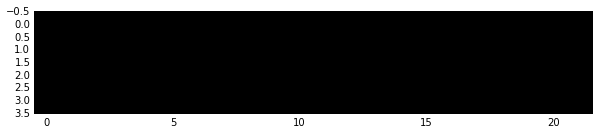

Predicted : 0
Label : 0.0


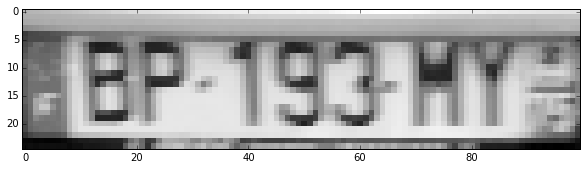

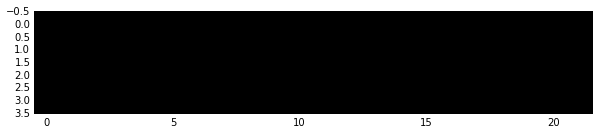

Predicted : 2
Label : 2.0


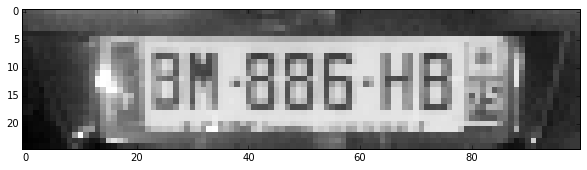

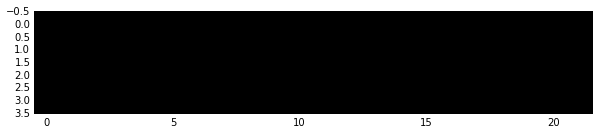

Predicted : 1
Label : 1.0


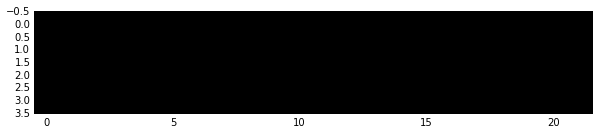

Predicted : 2
Label : 2.0


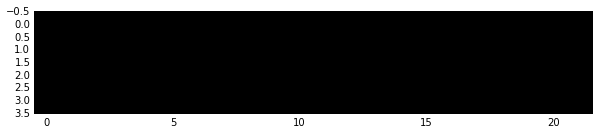

Predicted : 1
Label : 1.0


In [32]:
for i in range(50):  
    plt.imshow(solver.net.blobs['data'].data[i,0] ,cmap='gray')
    plt.show()
    plt.imshow(solver.net.blobs['ip2-alpha-conv'].data[i,0] ,cmap='gray')
    plt.show()
    print "Predicted :",np.argmax(solver.net.blobs['cls_score'].data[i])

    print "Label :", solver.net.blobs['label'].data[i]

In [57]:
solver.net.save('python/lenet1_image/lenet_train_test_position.caffemodel')

# Compute position feature map

In [38]:
net = caffe.Net("python/lenet1_image/lenet_train_test_position.prototxt",'train_caffe_position/lenet1_image/lenet_train_test_position.caffemodel',caffe.TEST)
params = ['fc6-new', 'fc7-new','cls_score-new']
# fc_params = {name: (weights, biases)}
fc_params = {pr: (net.params[pr][0].data, net.params[pr][1].data) for pr in params}

for fc in params:
    print '{} weights are {} dimensional and biases are {} dimensional'.format(fc, fc_params[fc][0].shape, fc_params[fc][1].shape)

Batch size :  100
Nombre de lignes: 83
Dimensions :  100 25
File results/C12/test_results.csv
Batch size 100
Image directory results/C12/
fc6-new weights are (4096, 3168) dimensional and biases are (4096,) dimensional
fc7-new weights are (1024, 4096) dimensional and biases are (1024,) dimensional
cls_score-new weights are (4, 1024) dimensional and biases are (4,) dimensional


In [39]:
# Load the fully convolutional network to transplant the parameters.
numclasses = 2
net_full_conv = caffe.Net('train_caffe_position/lenet1_image/lenet_train_test_position_featuremap.prototxt','train_caffe_position/lenet1_image/lenet_train_test_position.caffemodel',caffe.TEST)
params_full_conv = ['fc6-new-conv', 'fc7-new-conv','cls_score-new-conv']
# conv_params = {name: (weights, biases)}
conv_params = {pr: (net_full_conv.params[pr][0].data, net_full_conv.params[pr][1].data) for pr in params_full_conv}

for conv in params_full_conv:
    print '{} weights are {} dimensional and biases are {} dimensional'.format(conv, conv_params[conv][0].shape, conv_params[conv][1].shape)

fc6-new-conv weights are (4096, 36, 4, 22) dimensional and biases are (4096,) dimensional
fc7-new-conv weights are (1024, 4096, 1, 1) dimensional and biases are (1024,) dimensional
cls_score-new-conv weights are (4, 1024, 1, 1) dimensional and biases are (4,) dimensional


In [40]:
for pr, pr_conv in zip(params, params_full_conv):
    conv_params[pr_conv][0].flat = fc_params[pr][0].flat  # flat unrolls the arrays
    conv_params[pr_conv][1][...] = fc_params[pr][1]

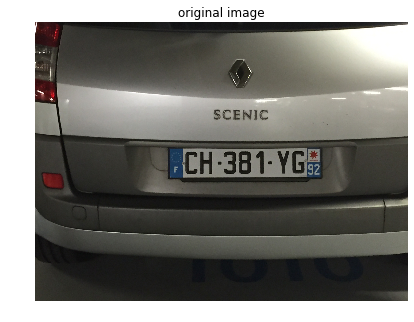

Factor 0.15318627451


(94, 125)

In [41]:
plt.rcParams['figure.figsize'] = (10, 5)
im = np.array(Image.open(DATA_ROOT+'plaques-alex/p35.jpg'))
plt.title("original image")
plt.imshow(im)
plt.axis('off')
plt.show()
im.shape
im_gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
factor = 500.0 / im_gray.shape[1] 
print "Factor",factor
im_gray = cv2.resize(im_gray,None, fx=factor, fy=factor, interpolation = cv2.INTER_AREA)
im_gray = cv2.resize(im_gray,None, fx=0.25, fy=0.25, interpolation = cv2.INTER_AREA)
#resize from 400x100 => 100x25, then /4
plt.title("Gray image")
plt.imshow(im_gray, cmap="gray")
plt.axis('off')
im_gray.shape

In [42]:
im_input = im_gray[np.newaxis, np.newaxis, :, :]
net_full_conv.blobs['data'].reshape(*im_input.shape)
net_full_conv.blobs['data'].data[...] = im_input * 0.00390625
print im_input.shape

(1, 1, 94, 125)


In [43]:
%%time
out = net_full_conv.forward()

CPU times: user 105 ms, sys: 4.69 ms, total: 109 ms
Wall time: 46.8 ms


cls_score LAYER :  (1, 4, 18, 8)
max :  (8, 4)


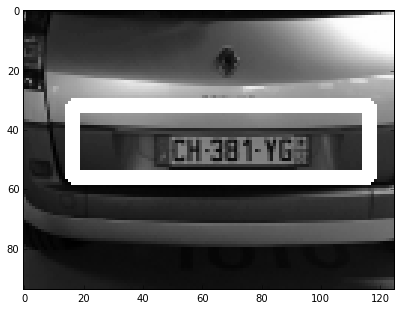

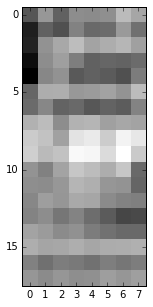

In [44]:
ss = out['cls_score'].shape
print "cls_score LAYER : ", ss
mm = np.unravel_index(out['cls_score'][0,0].argmax(), out['cls_score'][0,0].shape)
print "max : ", mm

# network stride = 4 
imx = copy.copy(net_full_conv.blobs['data'].data[0,0])*255
x = 4 * mm[1] + 50
y = 4 * mm[0] + 12
w = 100
h = 25
cv2.rectangle(imx,(x - w / 2,y - h /2),(x+w/2,y+h/2),(255,0,0),3)
plt.imshow(imx,cmap="gray")
plt.show()

for i in range(numclasses):
    plt.imshow(out['cls_score'][0,i],cmap="gray" )
    plt.show()

In [45]:
 [(k, v.data.shape) for k, v in net_full_conv.blobs.items()]

[('data', (1, 1, 94, 125)),
 ('conv1', (1, 20, 90, 121)),
 ('pool1', (1, 20, 45, 61)),
 ('conv2', (1, 50, 41, 57)),
 ('pool2', (1, 50, 21, 29)),
 ('dropout', (1, 50, 21, 29)),
 ('ip1-conv', (1, 500, 21, 29)),
 ('ip2-alpha-conv', (1, 36, 21, 29)),
 ('fc6', (1, 4096, 18, 8)),
 ('fc7', (1, 1024, 18, 8)),
 ('cls_score', (1, 4, 18, 8))]

Factor 0.78125
cls_score LAYER :  (1, 4, 18, 8)
max :  (12, 5)


Factor 0.78125
cls_score LAYER :  (1, 4, 18, 8)
max :  (11, 3)


Factor 0.204248366013
cls_score LAYER :  (1, 4, 36, 8)
max :  (12, 4)


Factor 0.204248366013
cls_score LAYER :  (1, 4, 36, 8)
max :  (14, 2)


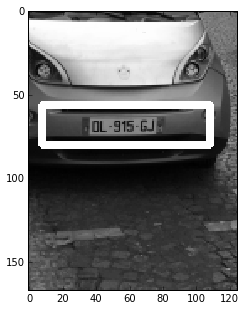

Factor 0.204248366013
cls_score LAYER :  (1, 4, 36, 8)
max :  (18, 3)


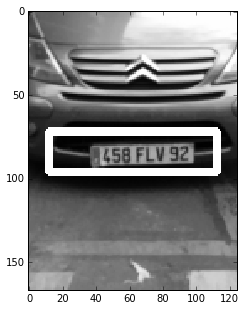

Factor 0.204248366013
cls_score LAYER :  (1, 4, 36, 8)
max :  (14, 6)


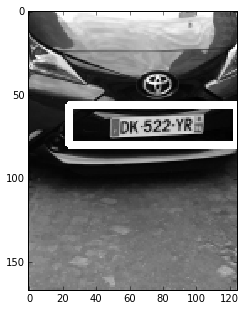

Factor 0.204248366013
cls_score LAYER :  (1, 4, 36, 8)
max :  (5, 1)


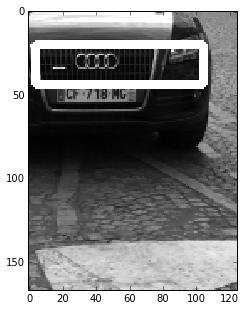

Factor 0.204248366013
cls_score LAYER :  (1, 4, 36, 8)
max :  (14, 1)


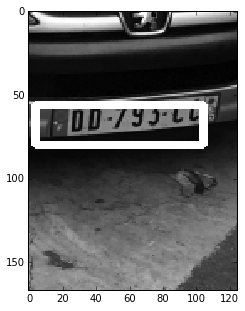

Factor 0.15318627451
cls_score LAYER :  (1, 4, 18, 8)
max :  (3, 2)


Factor 0.15318627451
cls_score LAYER :  (1, 4, 18, 8)
max :  (8, 6)


Factor 0.15318627451
cls_score LAYER :  (1, 4, 18, 8)
max :  (9, 1)


Factor 0.15318627451
cls_score LAYER :  (1, 4, 18, 8)
max :  (0, 6)


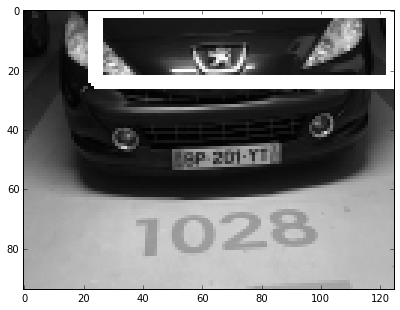

Factor 0.15318627451
cls_score LAYER :  (1, 4, 18, 8)
max :  (4, 1)


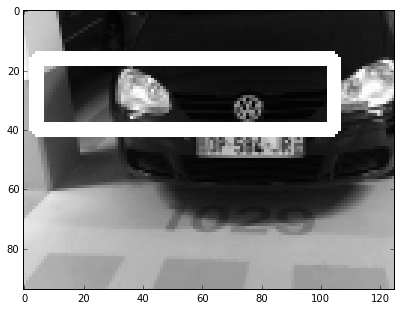

Factor 0.15318627451
cls_score LAYER :  (1, 4, 18, 8)
max :  (1, 4)


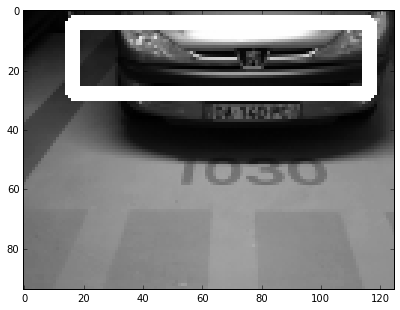

Factor 0.15318627451
cls_score LAYER :  (1, 4, 18, 8)
max :  (8, 6)


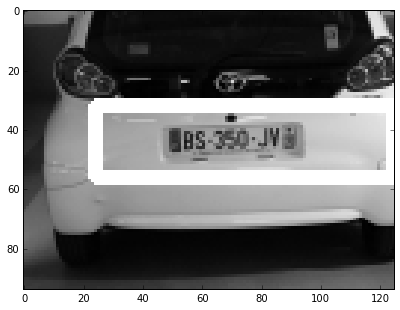

Factor 0.15318627451
cls_score LAYER :  (1, 4, 18, 8)
max :  (7, 7)


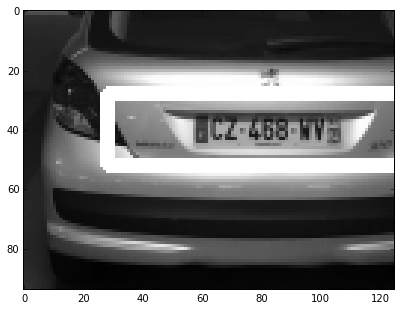

Factor 0.15318627451
cls_score LAYER :  (1, 4, 18, 8)
max :  (12, 5)


Factor 0.15318627451
cls_score LAYER :  (1, 4, 18, 8)
max :  (9, 5)


Factor 0.15318627451
cls_score LAYER :  (1, 4, 18, 8)
max :  (14, 6)


Factor 0.15318627451
cls_score LAYER :  (1, 4, 18, 8)
max :  (15, 7)


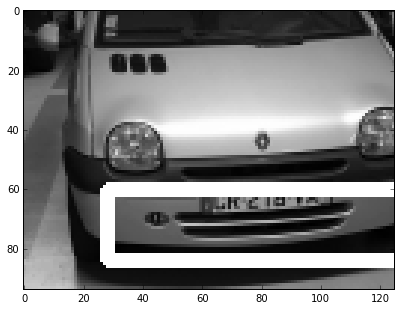

Factor 0.15318627451
cls_score LAYER :  (1, 4, 18, 8)
max :  (7, 1)


Factor 0.15318627451
cls_score LAYER :  (1, 4, 18, 8)
max :  (5, 1)


Factor 0.15318627451
cls_score LAYER :  (1, 4, 18, 8)
max :  (8, 7)


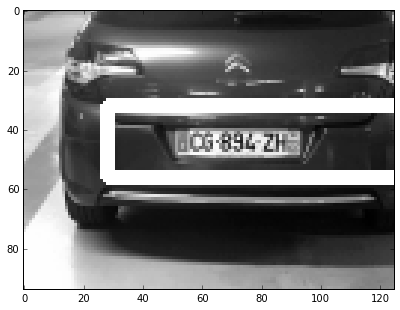

Factor 0.15318627451
cls_score LAYER :  (1, 4, 18, 8)
max :  (11, 6)


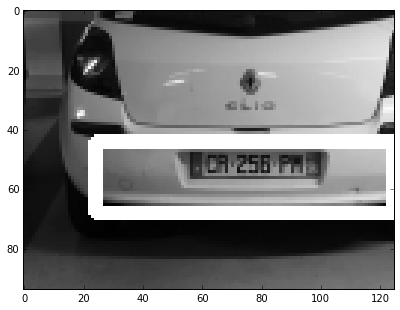

Factor 0.15318627451
cls_score LAYER :  (1, 4, 18, 8)
max :  (8, 5)


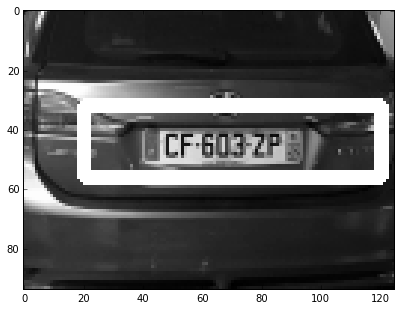

Factor 0.15318627451
cls_score LAYER :  (1, 4, 18, 8)
max :  (9, 6)


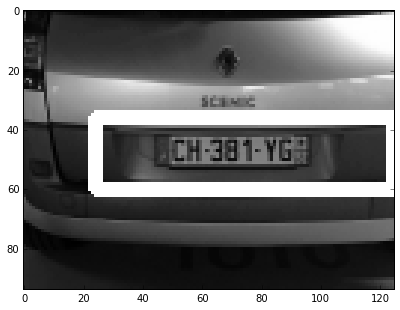

Factor 0.15318627451
cls_score LAYER :  (1, 4, 18, 8)
max :  (9, 3)


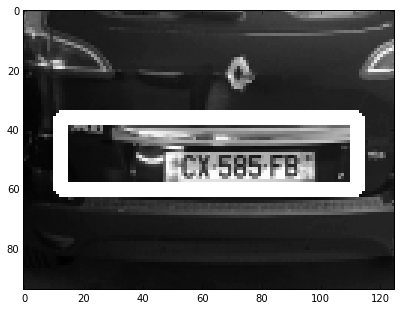

Factor 0.15318627451
cls_score LAYER :  (1, 4, 18, 8)
max :  (6, 0)


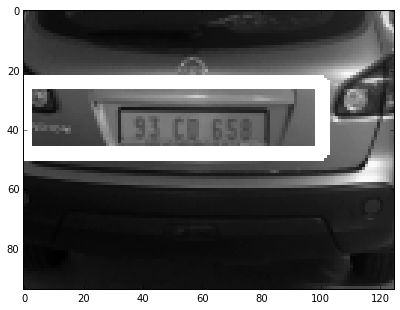

Factor 0.15318627451
cls_score LAYER :  (1, 4, 18, 8)
max :  (13, 5)


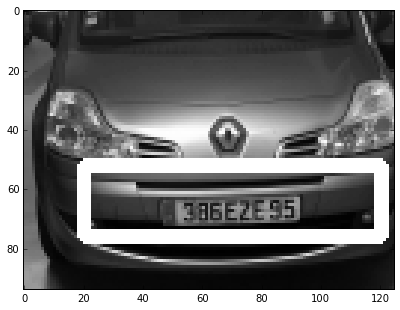

Factor 0.15318627451
cls_score LAYER :  (1, 4, 18, 8)
max :  (13, 7)


Factor 0.15318627451
cls_score LAYER :  (1, 4, 18, 8)
max :  (11, 7)


Factor 0.15318627451
cls_score LAYER :  (1, 4, 18, 8)
max :  (8, 6)


Factor 0.15318627451
cls_score LAYER :  (1, 4, 18, 8)
max :  (9, 5)


Factor 0.15318627451
cls_score LAYER :  (1, 4, 18, 8)
max :  (10, 5)


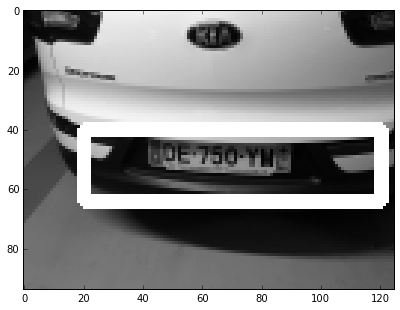

Factor 0.15318627451
cls_score LAYER :  (1, 4, 18, 8)
max :  (10, 6)


Factor 0.15318627451
cls_score LAYER :  (1, 4, 18, 8)
max :  (7, 4)


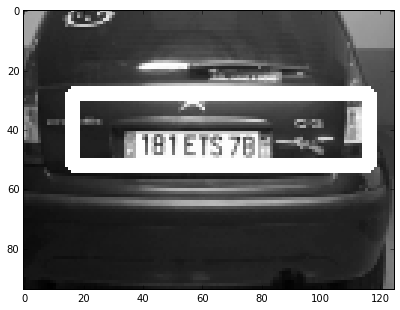

Factor 0.15318627451
cls_score LAYER :  (1, 4, 18, 8)
max :  (8, 7)


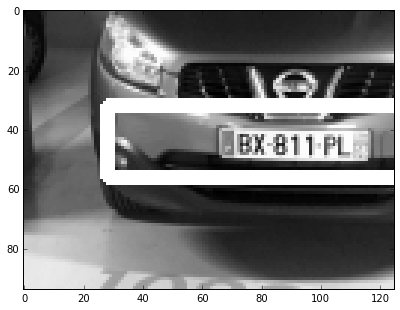

Factor 0.15318627451
cls_score LAYER :  (1, 4, 18, 8)
max :  (10, 4)


Factor 0.15318627451
cls_score LAYER :  (1, 4, 18, 8)
max :  (7, 4)


Factor 0.15318627451
cls_score LAYER :  (1, 4, 18, 8)
max :  (8, 4)


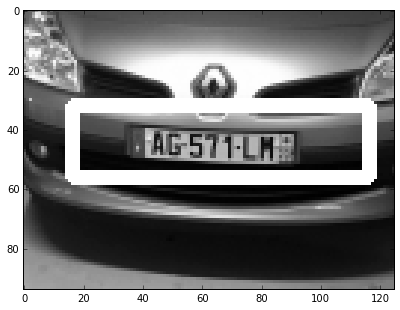

Factor 0.15318627451
cls_score LAYER :  (1, 4, 18, 8)
max :  (7, 2)


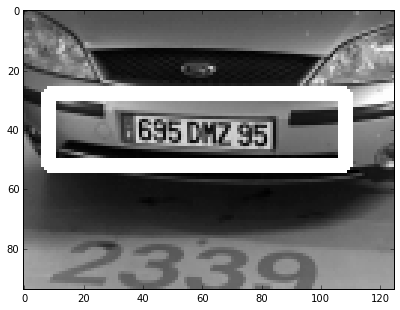

Factor 0.15318627451
cls_score LAYER :  (1, 4, 18, 8)
max :  (5, 4)


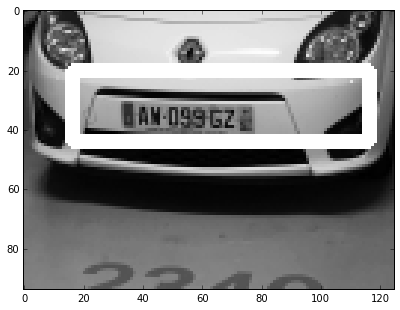

Factor 0.15318627451
cls_score LAYER :  (1, 4, 18, 8)
max :  (6, 4)


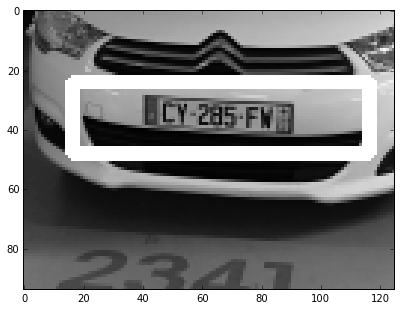

Factor 0.15318627451
cls_score LAYER :  (1, 4, 18, 8)
max :  (7, 6)


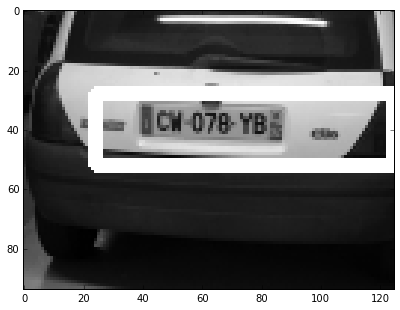

Factor 0.15318627451
cls_score LAYER :  (1, 4, 18, 8)
max :  (6, 3)


Factor 0.15318627451
cls_score LAYER :  (1, 4, 18, 8)
max :  (4, 2)


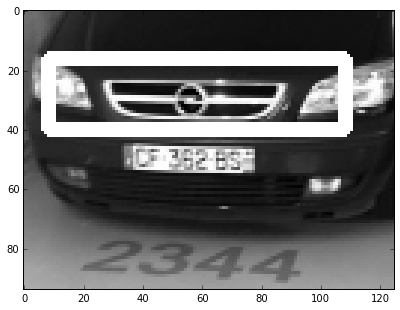

Factor 0.15318627451
cls_score LAYER :  (1, 4, 18, 8)
max :  (6, 6)


Factor 0.15318627451
cls_score LAYER :  (1, 4, 18, 8)
max :  (9, 7)


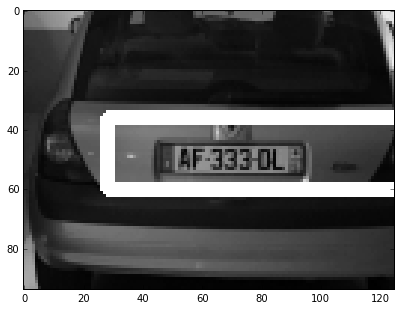

Factor 0.15318627451
cls_score LAYER :  (1, 4, 18, 8)
max :  (7, 5)


Factor 0.15318627451
cls_score LAYER :  (1, 4, 18, 8)
max :  (5, 3)


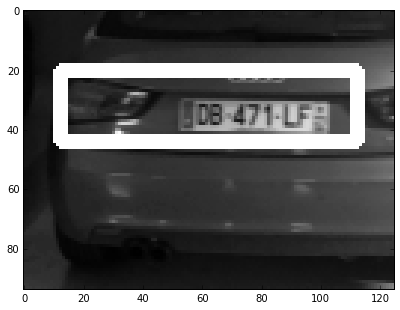

In [46]:
def compute(path):
    plt.rcParams['figure.figsize'] = (10, 5)
    im = np.array(Image.open(path))
    #plt.title("original image")
    #plt.imshow(im)
    #plt.axis('off')
    #plt.show()
    im_gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    factor = 500.0 / im_gray.shape[1] 
    print "Factor",factor
    im_gray = cv2.resize(im_gray,None, fx=factor, fy=factor, interpolation = cv2.INTER_AREA)
    im_gray = cv2.resize(im_gray,None, fx=0.25, fy=0.25, interpolation = cv2.INTER_AREA)
    im_gray.shape
    im_input = im_gray[np.newaxis, np.newaxis, :, :]
    net_full_conv.blobs['data'].reshape(*im_input.shape)
    net_full_conv.blobs['data'].data[...] = im_input * 0.00390625
    out = net_full_conv.forward()
    ss = out['cls_score'].shape
    print "cls_score LAYER : ", ss
    mm = np.unravel_index(out['cls_score'][0,1].argmax(), out['cls_score'][0,1].shape)
    print "max : ", mm
    imx = copy.copy(net_full_conv.blobs['data'].data[0,0])*255
    x = 4 * mm[1] + 50
    y = 4 * mm[0] + 12
    w = 100
    h = 25
    cv2.rectangle(imx,(x - w / 2,y - h /2),(x+w/2,y+h/2),(255,0,0),3)
    plt.imshow(imx,cmap="gray")
    plt.show()
    
for i in range(10,60):
    compute(DATA_ROOT + 'plaques-alex/p' +str(i)+ '.jpg')

In [34]:
caffe_root = "/Users/christopherbourez/technologies/caffe/"

In [35]:
net = caffe.Net(caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt', 
                caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel', 
                caffe.TEST)

In [36]:
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_mean('data', np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1)) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

In [37]:
net.blobs['data'].reshape(50,3,227,227)
net.blobs['data'].data[...] = transformer.preprocess('data', caffe.io.load_image(caffe_root + 'examples/images/cat.jpg'))
out = net.forward()
print("Predicted class is #{}.".format(out['prob'][0].argmax()))

Predicted class is #281.


In [38]:
net.blobs['data'].reshape(50,3,227,227)
net.blobs['data'].data[...] = transformer.preprocess('data', caffe.io.load_image('input/p3.jpg'))
out = net.forward()
print("Predicted class is #{}.".format(out['prob'][0].argmax()))

Predicted class is #675.


In [39]:
imagenet_labels_filename = caffe_root + 'data/ilsvrc12/synset_words.txt'
try:
    labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')
except:
    !../data/ilsvrc12/get_ilsvrc_aux.sh
    labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')

# sort top k predictions from softmax output
top_k = net.blobs['prob'].data[0].flatten().argsort()[-1:-6:-1]
print labels[top_k]

['n03796401 moving van' 'n03670208 limousine, limo'
 'n03977966 police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria'
 'n03770679 minivan' 'n03769881 minibus']


In [92]:
net_full_conv = caffe.Net('bvlc_reference_caffenet-conv.prototxt', 'bvlc_reference_caffenet-conv.caffemodel',caffe.TEST)

In [93]:
net_full_conv.blobs['data'].data.shape

(1, 3, 451, 451)

[[282 282 281 281 281 281 277 282]
 [281 283 283 281 281 281 281 282]
 [283 283 283 283 283 283 287 282]
 [283 283 283 281 283 283 283 259]
 [283 283 283 283 283 283 283 259]
 [283 283 283 283 283 283 259 259]
 [283 283 283 283 259 259 259 277]
 [335 335 283 259 263 263 263 277]]


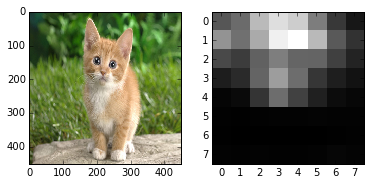

In [98]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# load input and configure preprocessing
im = caffe.io.load_image(caffe_root + 'examples/images/cat.jpg')
transformer = caffe.io.Transformer({'data': net_full_conv.blobs['data'].data.shape})
transformer.set_mean('data', np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1))
transformer.set_transpose('data', (2,0,1))
transformer.set_channel_swap('data', (2,1,0))
transformer.set_raw_scale('data', 255.0)
# make classification map by forward and print prediction indices at each location
out = net_full_conv.forward_all(data=np.asarray([transformer.preprocess('data', im)]))
print out['prob'][0].argmax(axis=0)
# show net input and confidence map (probability of the top prediction at each location)
plt.subplot(1, 2, 1)
plt.imshow(transformer.deprocess('data', net_full_conv.blobs['data'].data[0]))
plt.subplot(1, 2, 2)
plt.imshow(out['prob'][0,281])

In [91]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [77]:
im.shape

(360, 480, 3)

In [76]:
python cat.py /Users/christopherbourez/technologies/caffe/examples/images/cat.jpg

SyntaxError: invalid syntax (<ipython-input-76-4b5ec42c490d>, line 1)

In [254]:
net_full_conv = caffe.Net(caffe_root +"examples/net_surgery/bvlc_caffenet_full_conv.prototxt",caffe_root +"examples/net_surgery/bvlc_caffenet_full_conv.caffemodel",caffe.TEST)

NameError: name 'caffe_root' is not defined

In [251]:
np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1)

NameError: name 'caffe_root' is not defined

In [101]:
n = caffe.NetSpec()

In [102]:
n.from_proto(caffe_root +"examples/net_surgery/bvlc_caffenet_full_conv.prototxt")

KeyError: 'from_proto'

# Letter position

In [23]:
import sys
sys.path.insert(0, 'python')
sys.path.insert(0, '../../examples/fast-rcnn/caffe-fast-rcnn/python')
#sys.path.insert(0, '../../technologies/caffe/python')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import lmdb
import caffe
from caffe.proto import caffe_pb2
import cv2
import copy
import cv
import random
plt.rcParams['figure.figsize'] = (1, 1)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Image  22


(340, 400)

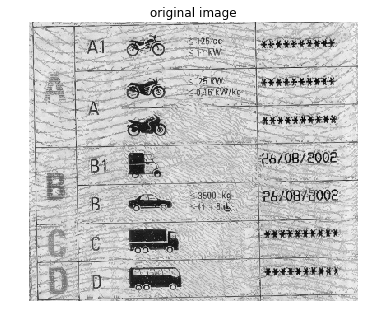

In [24]:
i =  random.randint(1, 354) 
print "Image ",i
plt.rcParams['figure.figsize'] = (10, 5)
im = np.array(Image.open(DATA_ROOT + 'permis_A_A1_extracted/' + str(i) + '.jpg'))* 0.00390625
plt.title("original image")
plt.imshow(im)
plt.axis('off')
im.shape #(322, 800, 3)

In [26]:
#net = caffe.Net('models/driving_featuremap.prototxt','models/driving_featuremap.caffemodel',caffe.TEST)

net = caffe.Net('python/driving_position_letters/train_val_featuremap.prototxt','python/driving_position_letters/train_val_featuremap.caffemodel',caffe.TEST)
for k, v in net.blobs.items():
    print (k, v.data.shape)

('data', (1, 1, 340, 400))
('conv1', (1, 20, 336, 396))
('pool1', (1, 20, 168, 198))
('conv2', (1, 50, 164, 194))
('pool2', (1, 50, 82, 97))
('ip1-conv', (1, 500, 79, 96))
('ip1-conv_relu1_0_split_0', (1, 500, 79, 96))
('ip1-conv_relu1_0_split_1', (1, 500, 79, 96))
('ip2-conv', (1, 2, 79, 96))
('bbox_pred-conv', (1, 2, 79, 96))


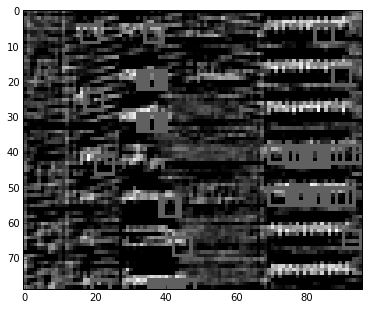

In [27]:
net.blobs['data'].data[...] = im
out = net.forward()
ind_flip = np.flipud(np.argsort(out["ip2-conv"][0,0], axis=None))
h,w = out["ip2-conv"][0,0].shape
imx = out["ip2-conv"][0,0] /0.00390625 
tx = out["bbox_pred-conv"][0,0]
ty = out["bbox_pred-conv"][0,1]
for i in range(50): cv2.rectangle(imx,(ind_flip[i]%w,ind_flip[i]/w),(ind_flip[i]%w+5,ind_flip[i]/w+5),(255,0,0),1)
plt.imshow(imx,cmap="gray")

Image 0 , 324.0 212.0
TX TY 0.00103506311774 0.051213516742
(20, 20)


Image 1 , 340.0 164.0
TX TY 0.238687354475 0.31886961773
(20, 20)


Image 2 , 328.0 164.0
TX TY 0.136859851778 0.275943780243
(20, 20)


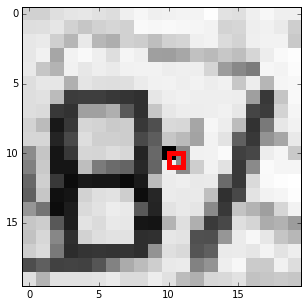

Image 3 , 332.0 164.0
TX TY 0.0602703041583 0.278461627215
(20, 20)


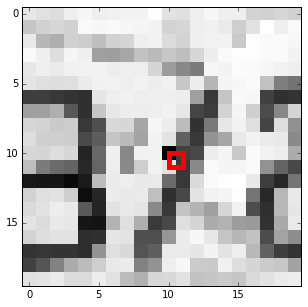

Image 4 , 312.0 164.0
TX TY -0.000959940925241 0.347977094054
(20, 20)


Image 5 , 352.0 212.0
TX TY -0.00994260698557 -0.14386923492
(20, 20)


Image 6 , 140.0 128.0
TX TY 0.332668536901 0.426190741658
(20, 20)


Image 7 , 304.0 164.0
TX TY 0.0261145763658 0.352127572894
(20, 20)


Image 8 , 312.0 212.0
TX TY 0.617934762239 -0.145349759459
(20, 20)


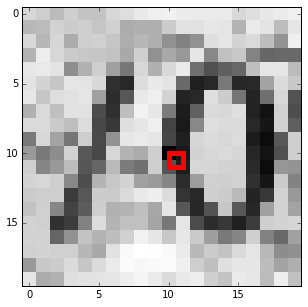

Image 9 , 88.0 176.0
TX TY 0.86130664587 0.0059221823886
(20, 20)


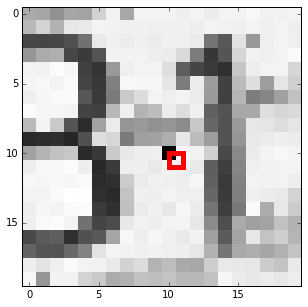

Image 10 , 144.0 80.0
TX TY 0.226937018782 0.395222363472
(20, 20)


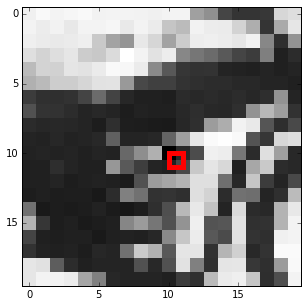

Image 11 , 360.0 164.0
TX TY 0.024727280736 0.0401698310673
(20, 20)


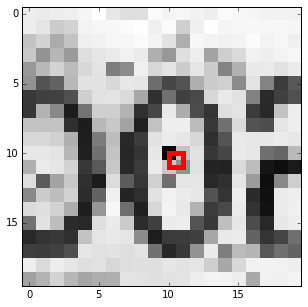

Image 12 , 300.0 164.0
TX TY 0.340208779573 0.337456657588
(20, 20)


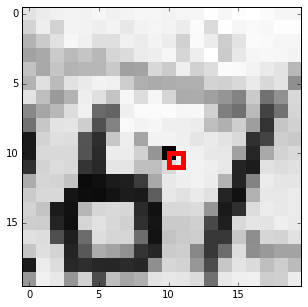

Image 13 , 140.0 80.0
TX TY 0.202279083133 0.738781903982
(20, 20)


Image 14 , 160.0 316.0
TX TY 0.121057614684 -0.485713599324
(20, 20)


Image 15 , 164.0 316.0
TX TY 0.221479447484 -0.292217936516
(20, 20)


Image 16 , 84.0 316.0
TX TY 0.0501722306013 0.152803256363
(20, 20)


Image 17 , 368.0 164.0
TX TY 0.229922107756 0.189081121683
(20, 20)


Image 18 , 156.0 316.0
TX TY 0.181755137295 -0.397242388427
(20, 20)


Image 19 , 332.0 212.0
TX TY 0.463366525769 -0.127930269688
(20, 20)


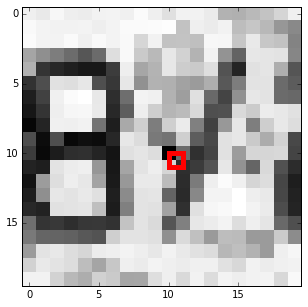

Image 20 , 152.0 316.0
TX TY 0.0894978907704 -0.319603201151
(20, 20)


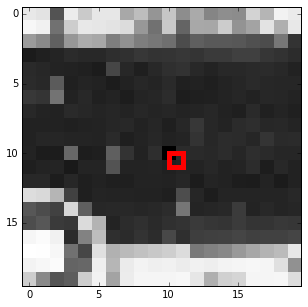

Image 21 , 316.0 212.0
TX TY -0.0706339065731 -0.156513941884
(20, 20)


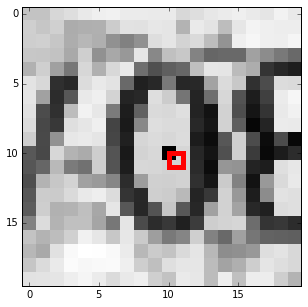

Image 22 , 304.0 168.0
TX TY 0.0395435799286 -0.310352102816
(20, 20)


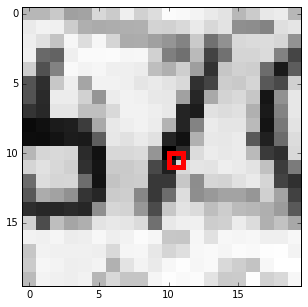

Image 23 , 304.0 212.0
TX TY 0.295825050324 0.111318474784
(20, 20)


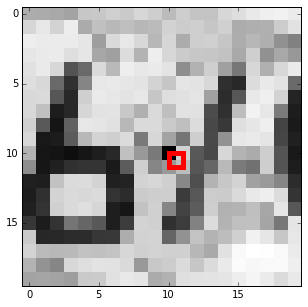

Image 24 , 180.0 316.0
TX TY 0.0385230586678 0.246492471993
(20, 20)


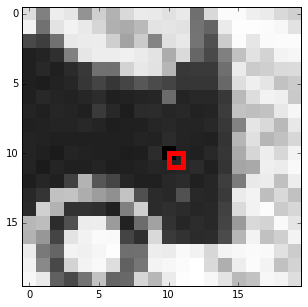

Image 25 , 136.0 128.0
TX TY 0.353415381908 0.768953259587
(20, 20)


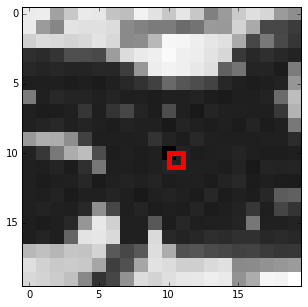

Image 26 , 148.0 128.0
TX TY 0.119747113436 0.167947200686
(20, 20)


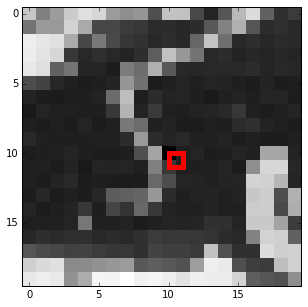

Image 27 , 360.0 212.0
TX TY 0.3862604177 -0.191866063178
(20, 20)


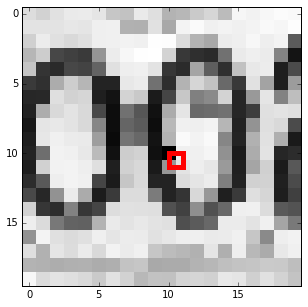

Image 28 , 356.0 76.0
TX TY 0.222156270593 -0.0686694280431
(20, 20)


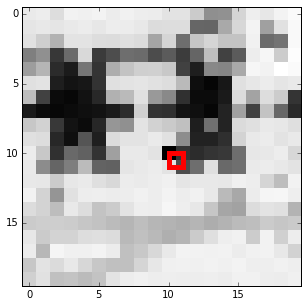

Image 29 , 308.0 208.0
TX TY -0.0938597740233 0.411858921647
(20, 20)


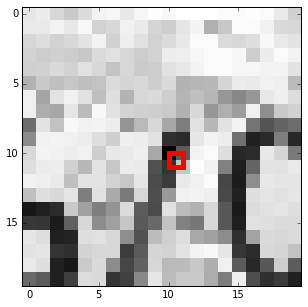

Image 30 , 164.0 224.0
TX TY -0.0647080527991 0.00957479462028
(20, 20)


Image 31 , 144.0 28.0
TX TY 0.321617201269 0.348961600065
(20, 20)


Image 32 , 284.0 212.0
TX TY 0.761819693446 0.167141398489
(20, 20)


Image 33 , 332.0 168.0
TX TY 0.0311380843818 -0.273728502989
(20, 20)


Image 34 , 148.0 80.0
TX TY 0.257376935482 0.0773631248623
(20, 20)


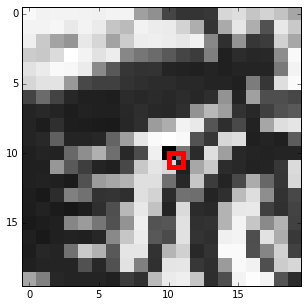

Image 35 , 328.0 212.0
TX TY -0.217993682623 0.0280023967661
(20, 20)


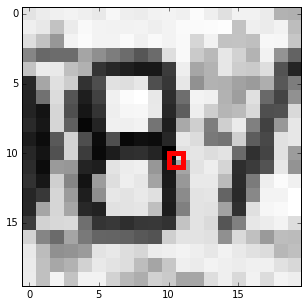

Image 36 , 148.0 316.0
TX TY 0.0594086582586 0.0292780396715
(20, 20)


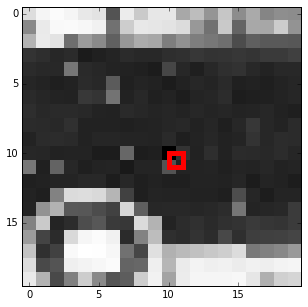

Image 37 , 160.0 224.0
TX TY 0.170391877592 -0.193638237417
(20, 20)


Image 38 , 144.0 128.0
TX TY 0.210191062242 0.158908576965
(20, 20)


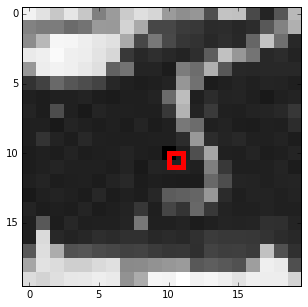

Image 39 , 76.0 104.0
TX TY -0.0338689509779 0.0314035042375
(20, 20)


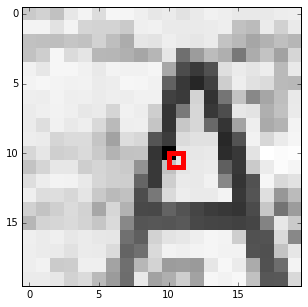

Image 40 , 324.0 164.0
TX TY -0.258821350634 0.33141812548
(20, 20)


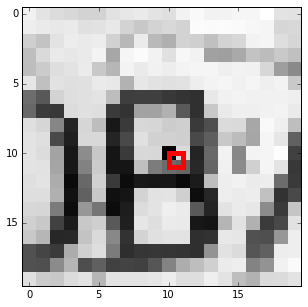

Image 41 , 336.0 28.0
TX TY 0.574534686804 -0.12019501254
(20, 20)


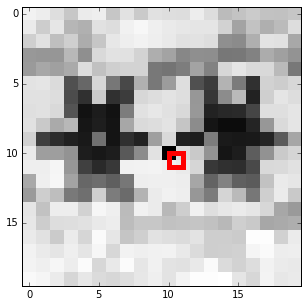

Image 42 , 176.0 268.0
TX TY 0.205081425309 0.694747080207
(20, 20)


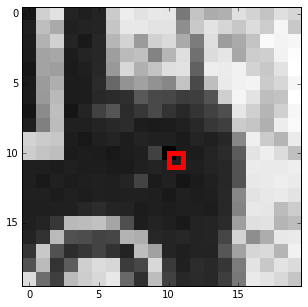

Image 43 , 168.0 316.0
TX TY 0.210686565489 -0.0642469000444
(20, 20)


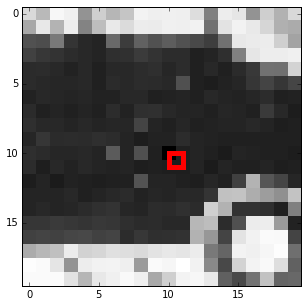

Image 44 , 72.0 28.0
TX TY 0.299869876504 0.338116892576
(20, 20)


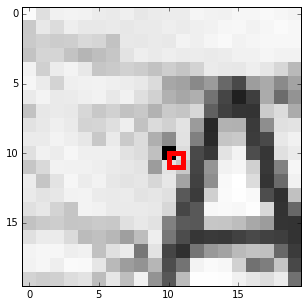

Image 45 , 312.0 168.0
TX TY 0.0321771260723 -0.370002552271
(20, 20)


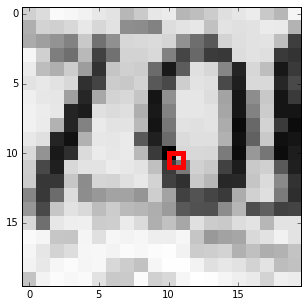

Image 46 , 368.0 260.0
TX TY 0.450185925364 -0.200470284224
(20, 20)


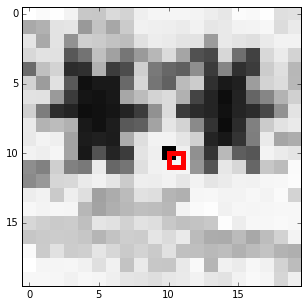

Image 47 , 308.0 212.0
TX TY -0.0499694670737 -0.289254231751
(20, 20)


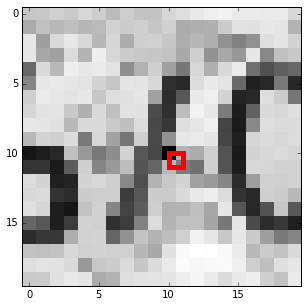

Image 48 , 136.0 80.0
TX TY 0.303163163662 1.18911004722
(20, 20)


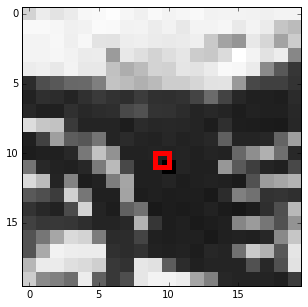

Image 49 , 284.0 164.0
TX TY 0.185668130517 0.224764093757
(20, 20)


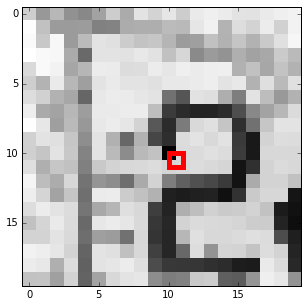

In [28]:
def get_position_w( y ) :
  return im.shape[1] / 2.0 + 2.0 * 2.0 * ( y - w / 2.0);

def get_position_h( y ) :
  return im.shape[0] / 2.0 + 2.0 * 2.0 * ( y - h / 2.0);

variance = 1.33

for i in range(50):
    x = get_position_w(ind_flip[i]%w)
    y = get_position_h(ind_flip[i]/w)
    t_x = tx[ind_flip[i]/w,ind_flip[i]%w]*variance
    t_y = ty[ind_flip[i]/w,ind_flip[i]%w]*variance
    print "Image",i,",",x,y
    print "TX TY",t_x,t_y
    imy = copy.copy(im[ (y-10):(y+10), (x-10):(x+10) ])/0.00390625
    print imy.shape
    currentAxis = plt.gca()
    coords = (10 -  int(t_y), 10 - int(t_x)), 1, 1
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor='r', linewidth=5))
    
    imy[ 10 + int(t_y)  , 10 + int(t_x) ] = 0
    plt.imshow(  imy  )
    plt.show()

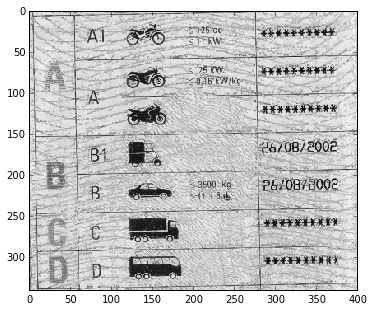

In [29]:
plt.imshow(im)
plt.show()

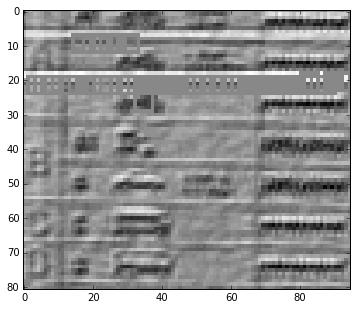

In [309]:
out = net.forward()
ind = np.argsort(out["ip2-conv"][0,0], axis=None)
h,w = out["ip2-conv"][0,0].shape
pick = []
while len(ind) > 0:
    i = ind[-1]
    #print i
    pick.append(i)
    ind = ind[:-1]

    x_cur = i % w
    y_cur = i / w
    
    X_cur = ind % w
    Y_cur = ind / w
    
    d = np.sqrt( (x_cur - X_cur) * (x_cur - X_cur) + (y_cur - Y_cur) * (y_cur - Y_cur) )
    #print d.shape
    #print np.nonzero(d >= 0)[0]
    ind = ind[np.nonzero(d >= 2)[0]]
out = net.forward()
imx = out["ip2-conv"][0,0]
for i in range(50): 
    x1 = pick[i]%w
    y1 = pick[i]/w
    cv2.rectangle(imx,(x1,y1),(x1+5,y1+5),(255,0,0),1)
plt.imshow(imx,cmap="gray")